**Общая информация:**

Для стартапа, который продаёт продукты питания, необходимо проанализировать поведение пользователей мобильного приложения. Изучив воронку продаж, необходимо оценить путь пользователя до покупки, количество пользователей, которые доходят до покупки и на каких шагах они застревают. 

Для принятия решения об изменении шрифта в приложении был проведен A/A/B-эксперимент, пользователи были разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо установить, влияет ли изменение шрифта на поведение пользователей.

**Задача проекта:** проанализировать воронку продаж, проанализировать результаты A/A/B-эксперимента и дать рекомендации о возможности изменения шрифта

### Импорт данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime as dt
from datetime import timedelta
from datetime import time
import scipy.stats as st
import plotly.express as px
from plotly import graph_objects as go
import math as mth

In [2]:
# Импортируем данные
data=pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


*В таблице отсутствуют строки с пропусками. Необходимо заменить название столбцов и формат даты*

### Предобработка данных

In [4]:
# Переименуем столбцы
data=data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id', \
                          'EventTimestamp':'date', 'ExpId':'exp_id'})

In [5]:
# Заменим формат в столбце с датой
data['date']=pd.to_datetime(data['date'], unit='s')

In [6]:
# Проверим наличие дубликатов
print('количество явных дубликатов:', data.duplicated().sum())

количество явных дубликатов: 413


In [7]:
# удалим дубликаты
data=data.drop_duplicates().reset_index(drop=True)

In [8]:
print('количество явных дубликатов после обработки:', data.duplicated().sum())

количество явных дубликатов после обработки: 0


In [9]:
# Заменим добавим столбец с датой
data['dt']=data['date'].dt.date

In [10]:
data.head()

event_name              user_id                date  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

           dt  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25

In [11]:
# Посчитаем количество событий в логе
print('Количество событий в логе:', data['event_name'].count())

Количество событий в логе: 243713


In [12]:
# Посчитаем количество уникальных пользователей
print('Количество уникальных пользователей в логе:', data['user_id'].nunique())

Количество уникальных пользователей в логе: 7551


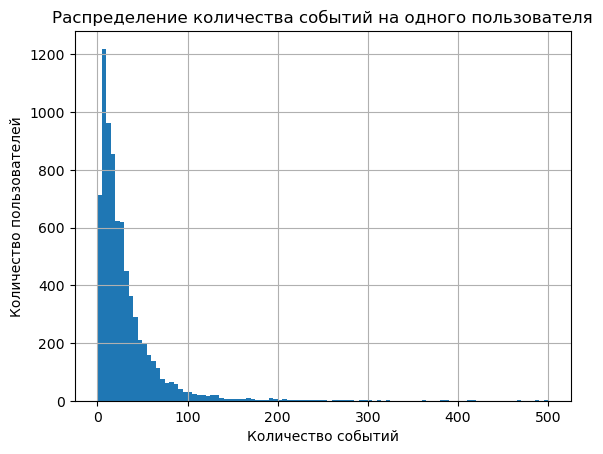

In [13]:
# Рассмотрим количество событий, которое приходится на одного пользователя
data.groupby('user_id').agg({'event_name':'count'}).hist(bins=100, range=(0,500))
plt.title('Распределение количества событий на одного пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

In [14]:
data.groupby('user_id').agg({'event_name':'count'}).describe()

event_name
count  7551.000000
mean     32.275593
std      65.154219
min       1.000000
25%       9.000000
50%      20.000000
75%      37.000000
max    2307.000000

На большую часть пользователей приходится до 50 событий, однако, есть отдельные пользователи с аномально высоким количеством событий, рассмотрим их подробнее. 

In [15]:
# Составим профили пользователей
event_cnt=(
    data.groupby(['user_id', 'event_name'])
    .agg(cnt=('event_name','count'), date_min=('date','min'), date_max=('date', 'max'))
    .reset_index()
)
event_cnt

user_id               event_name  cnt            date_min  \
0         6888746892508752         MainScreenAppear    1 2019-08-06 14:06:34   
1         6909561520679493         CartScreenAppear    1 2019-08-06 18:52:58   
2         6909561520679493         MainScreenAppear    2 2019-08-06 18:52:54   
3         6909561520679493       OffersScreenAppear    1 2019-08-06 18:53:04   
4         6909561520679493  PaymentScreenSuccessful    1 2019-08-06 18:52:58   
...                    ...                      ...  ...                 ...   
20190  9220879493065341500         CartScreenAppear    1 2019-08-02 17:59:16   
20191  9220879493065341500         MainScreenAppear    5 2019-07-29 14:29:58   
20192  9220879493065341500       OffersScreenAppear    1 2019-08-02 17:59:00   
20193  9221926045299980007         MainScreenAppear    7 2019-08-01 17:30:27   
20194  9222603179720523844         MainScreenAppear   59 2019-08-01 06:52:13   

                 date_max  
0     2019-08-06 14:06:34  
1     2019-08-06 18:52:58  
2     2019-08-06 18:52:58  
3     2019-08-06 18:53:04  
4     2019-08-06 18:52:58  
...                   ...  
20190 2019-08-02 17:59:16  
20191 2019-08-03 14:17:53  
20192 2019-08-02 17:59:00  
20193 2019-08-05 16:45:59  
20194 2019-08-07 09:16:20  

[20195 rows x 5 columns]

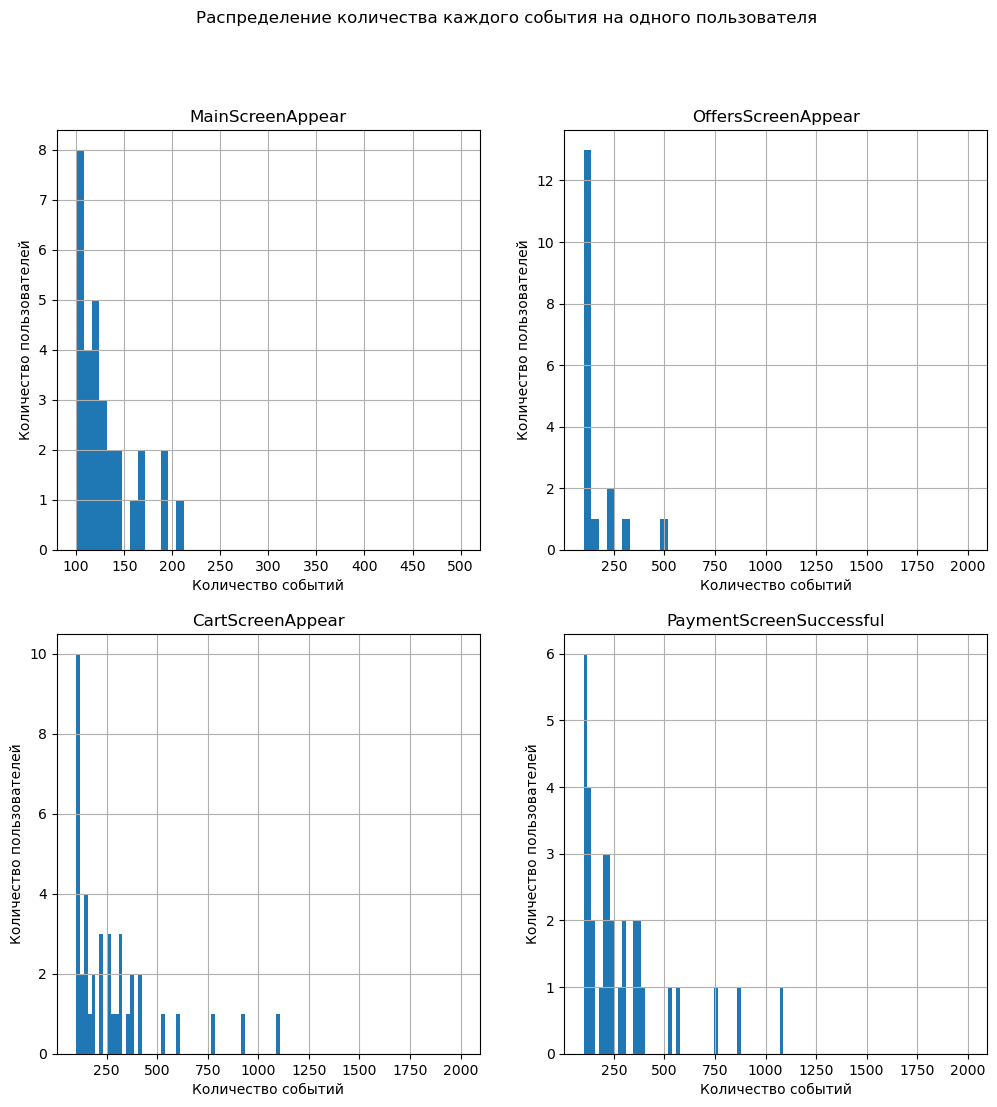

In [16]:
# Рассмотрим выбросы по каждому действию на гистограммах
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2, 2, 1)
ax1=event_cnt[event_cnt['event_name']=='MainScreenAppear']['cnt'].hist(bins=50, range=(100,500))
ax1.set_title('MainScreenAppear')
ax1.set_xlabel('Количество событий')
ax1.set_ylabel('Количество пользователей')
ax2=fig.add_subplot(2, 2, 2)
ax2=event_cnt[event_cnt['event_name']=='OffersScreenAppear']['cnt'].hist(bins=50, range=(100,2000))
ax2.set_title('OffersScreenAppear')
ax2.set_xlabel('Количество событий')
ax2.set_ylabel('Количество пользователей')
ax3=fig.add_subplot(2, 2, 3)
ax3=event_cnt[event_cnt['event_name']=='CartScreenAppear']['cnt'].hist(bins=100, range=(100,2000))
ax3.set_title('CartScreenAppear')
ax3.set_xlabel('Количество событий')
ax3.set_ylabel('Количество пользователей')
ax4=fig.add_subplot(2, 2, 4)
ax4=event_cnt[event_cnt['event_name']=='PaymentScreenSuccessful']['cnt'].hist(bins=100, range=(100,2000))
ax4.set_xlabel('Количество событий')
ax4.set_ylabel('Количество пользователей')
ax4.set_title('PaymentScreenSuccessful')
plt.suptitle('Распределение количества каждого события на одного пользователя')

plt.show()

In [17]:
# Рассмотрим какие действия наиболее часто совершались более 100 раз
event_cnt[event_cnt['cnt']>100]['event_name'].value_counts()

CartScreenAppear           40
PaymentScreenSuccessful    34
MainScreenAppear           29
OffersScreenAppear         18
Name: event_name, dtype: int64

In [18]:
# Рассмотрим какие действия наиболее часто совершались более 500 раз
event_cnt[event_cnt['cnt']>500]['event_name'].value_counts()

CartScreenAppear           5
PaymentScreenSuccessful    5
OffersScreenAppear         1
Name: event_name, dtype: int64

Из представленных данных видно, что выбросы наиболее часто встречаются для событий CartScreenAppear, paymentScreenSuccful. Возможно, это связано с тем, что пользователи сталкиваются с проблемами при оплате и дейсвтие приходится повторять несколько раз. Данная особенность также может быть рассмотрена в других исследованиях. 

Так как в данных присутствуют выбросы рассмотрим медианное значение событий, приходящиеся на пользователя

In [19]:
print(f"В среднем на пользователя приходится {data.groupby('user_id')['event_name'].count().median()} событий")

В среднем на пользователя приходится 20.0 событий


In [20]:
# Найдем начало и конец датасета
print(f"Начало тестирования:{data['date'].min()}, конец тестирования: {data['date'].max()}")


Начало тестирования:2019-07-25 04:43:36, конец тестирования: 2019-08-07 21:15:17


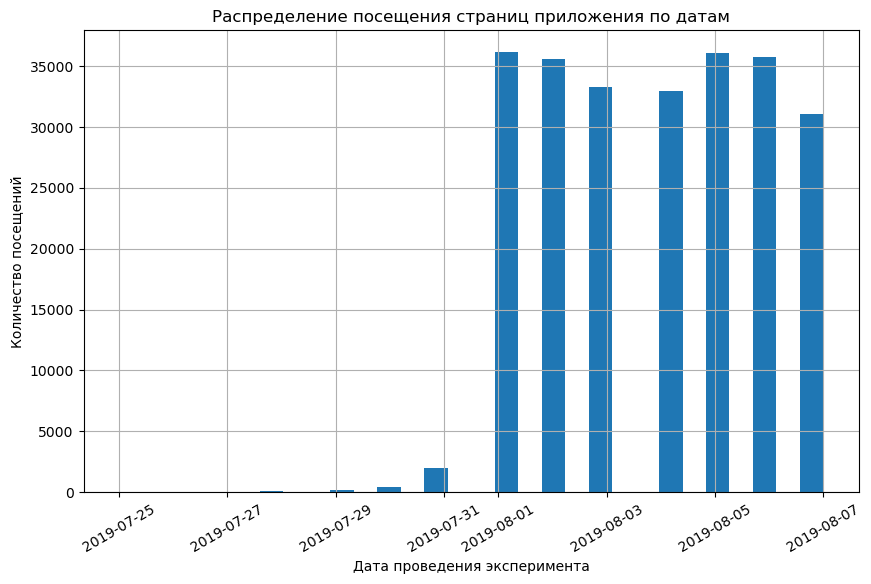

In [21]:
# Построим распределение событий по датам
plt.figure(figsize=(10,6))
data['dt'].hist(bins=30)
plt.xticks(rotation=30)
plt.title('Распределение посещения страниц приложения по датам')
plt.xlabel('Дата проведения эксперимента')
plt.ylabel('Количество посещений')
plt.show()

Основная выборка тестирования начинается с первого августа, данные в первые дни могли доходить от заказов, начавшихся до старта тестирования. Рассмотрим, сколько событий было совершено до 1 августа

In [22]:
print('Число событий до 1 августа:', len(data[data['dt']<datetime.date(2019, 8, 1)]))

Число событий до 1 августа: 2826


In [23]:
print('Процент событий до 1 августа от общего числа событий:', \
      "{0:.3f}".format(len(data[data['dt']<datetime.date(2019, 8, 1)])*100/len(data)))

Процент событий до 1 августа от общего числа событий: 1.160


In [24]:
# Рассмотрим, какой процент уникальных пользователей мы теряем при срезе от 1 августа
print('Процент пользователей до 1 августа от общего числа пользователей:', \
      round((data['user_id'].nunique()\
       -data[data['dt']>datetime.date(2019, 7, 31)]['user_id'].nunique())*100\
            /data['user_id'].nunique(),4))

Процент пользователей до 1 августа от общего числа пользователей: 0.2251


Количество событий, произошедших до 1 августа составляет 1,16% от общего количества.
Доля пользователей, соверших события только до 1 августа составляет 0,22%
Таким образом, действительным началом проведения теста можно считать 1 августа. 

In [25]:
# Сделаем срез данных от 1 агуста
data_new=data[data['dt']>datetime.date(2019, 7, 31)]
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   date        240887 non-null  datetime64[ns]
 3   exp_id      240887 non-null  int64         
 4   dt          240887 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.0+ MB


In [26]:
# Посчитаем количество событий в срезанных данных
print('Количество событий в логе после среза:', data_new['event_name'].count())

Количество событий в логе после среза: 240887


In [27]:
# Посчитаем количество уникальных пользователей в срезанных данных
print('Количество уникальных пользователей в логе после среза:', data_new['user_id'].nunique())

Количество уникальных пользователей в логе после среза: 7534


In [28]:
# Посчитаем медианное количество событий на пользователя после среза
print(f"В среднем на пользователя приходится {data_new.groupby('user_id')['event_name'].count().median()} событий")

В среднем на пользователя приходится 19.0 событий


In [29]:
# Проверим наличие пользователей во всех трех группах
data_new.groupby('exp_id')['user_id'].nunique()
data_new.groupby('exp_id').agg({'user_id':'nunique'})

user_id
exp_id         
246        2484
247        2513
248        2537

In [30]:
# Пользователи есть во всех трех группах, проверим, что нет пересечений по группам
data_new.groupby('exp_id').agg({'user_id':'nunique'}).sum()

user_id    7534
dtype: int64

Сумма пользователей, разбитых по группам, равна сумме уникальных пользователей, пересечений нет

**Выводы по пункту предобработка данных:**

На этапе предобработки данных были выполнены следующие действия:

- столбцу с датой и временем был присвоен соответствующий формат
- удалены дубликаты
- дата события выделена в отдельный столбец
- переименованы столбцы
- установлено, что на некоторых пользователей приходится аномальное количество событий, рассчитано медианное значение событий, которое приходится на каждого пользователя
- выбросы наиболее часто встречаются для событий CartScreenAppear, paymentScreenSuccful. Возможно, это связано с тем, что пользователи сталкиваются с проблемами при оплате и дейсвтие приходится повторять несколько раз. Данная проблема также может быть проанализирована в дальнейших исследованиях
- посчитано общее количество событий
- посчитано количество уникальных пользователей
- установлено, что начало тестирования приходится на 25 июля, конец - на 7 агуста
- установлено, что в период до 1 августа было совершено 1,16% событий от общего числа событий, в этой выборке участвовали 0,22% пользователей от общего числа уникальных пользователей. Техничски возможно, что данные в первые дни могли доходить от заказов, начавшихся до старта тестирования. На основании этого сделан срез выборки и началом исследования установлено 1 августа
- установлено, что пользователи распределены по трем группам без пересечений


### Анализ воронки событий

#### Анализ событий

In [31]:
# Зададим функцию для подсчета показателей
def events(table, index, values, func, sort, columns=None):
    pivot=table.pivot_table(index=index, columns=columns, values=values, aggfunc=func).sort_values(by=sort, ascending=False)
    return pivot

In [32]:
# Посчитаем, сколько раз совершалось каждое событие
all_events=events(data_new, 'event_name', 'user_id', 'count', 'user_id')
all_events=all_events.rename(columns={'user_id':'cnt_users'})
all_events

cnt_users
event_name                        
MainScreenAppear            117328
OffersScreenAppear           46333
CartScreenAppear             42303
PaymentScreenSuccessful      33918
Tutorial                      1005

In [33]:
# Зададим функцию, для построения графиков
def plot(x, y, data):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax=sns.barplot(x=x, y=y, data=data)
    for bar in ax.patches:
           ax.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                  textcoords='offset points')

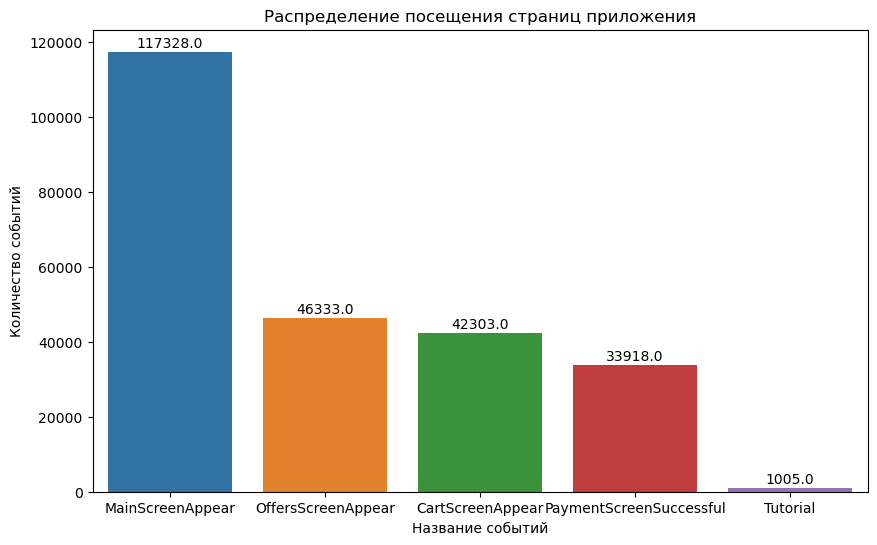

In [34]:
# Построим распределениее событий
plot(all_events.index, 'cnt_users', all_events)
plt.title('Распределение посещения страниц приложения')
plt.ylabel('Количество событий')
plt.xlabel('Название событий')
plt.show()

In [35]:
# Зададим функцию для нахождения долей событий
def share(data, value, title):
    plt.figure(figsize=(10,8))
    data[value].plot(kind='pie', labels=None, label='', autopct='%.2f%%', \
                       legend=True, title=title,cmap='YlOrRd')
    plt.show()

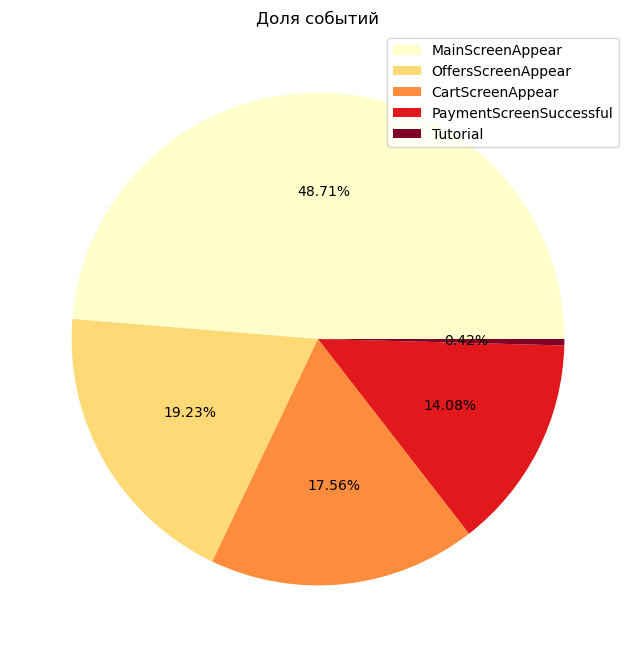

In [36]:
share(all_events, 'cnt_users', 'Доля событий')

- Наиболее часто происходящее событие - открытие главного экрана (48% от общего числа событий)
- За ним следует страница с предложениями товаров (19% от общего числа событий)
- Далее следуют страницы с оплатой и успешное завершение оплаты (17% от общего числа событий
- Наименьшее количество раз встречается обучение (менее 1%), скорее всего, пользователи в основном пропускают данный этап 

Из полученных данных видим, что наибольшее падение в между этапами наблюдается при переходе с главной страницы на страницу с предложениями 

#### Анализ пользователей

In [37]:
# Посчитаем количество пользователей, совершивших каждое событие
events_per_users=events(data_new, 'event_name', 'user_id', 'nunique', 'user_id') 
# Посчитаем долю пользователей, совершивших каждое событие
events_per_users['share']=round(events_per_users['user_id']/data_new['user_id'].nunique(), 2)
events_per_users=events_per_users.rename(columns={'user_id':'cnt_users'})
events_per_users

cnt_users  share
event_name                               
MainScreenAppear              7419   0.98
OffersScreenAppear            4593   0.61
CartScreenAppear              3734   0.50
PaymentScreenSuccessful       3539   0.47
Tutorial                       840   0.11

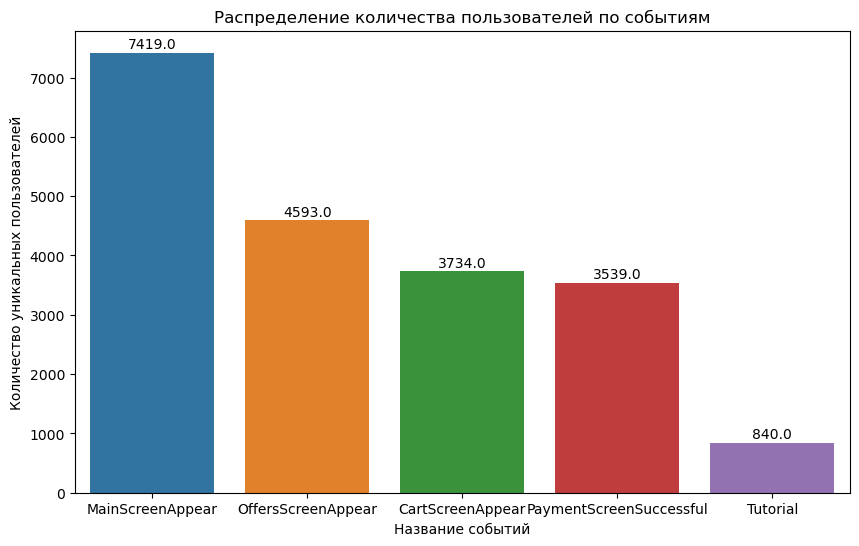

In [38]:
# Построим распределение количества пользователей по событиям
plot(events_per_users.index, 'cnt_users', events_per_users)
plt.title('Распределение количества пользователей по событиям')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Название событий')
plt.show()

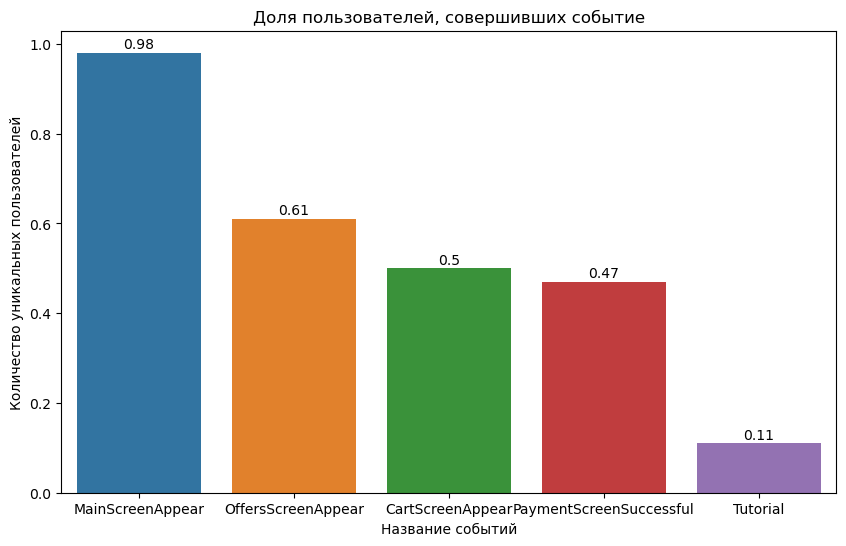

In [39]:
# Построим распределение долей пользователей, совершивших каждое событие
plot(events_per_users.index, 'share', events_per_users)
plt.title('Доля пользователей, совершивших событие')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Название событий')
plt.show()

- Из полученных данных видим, что на главный экран переходит 98% пользователей, таким образом, можно предположить, что пользователи могут перейти к страницу с товарами, минуя данный этап
- Наибольший процент пользователей теряется при переходе с главной страницы на страницу с товарами
- До момента оплаты доходят 47% пользователей
- Обучение проходит только 11% пользователей

На основании анализа распределения количества событий и пользователей можно предположить, что воронка событий выстраивается в следующем порядке:
MainScreenAppear-OffersScreenAppear-CartScreenAppear-PaymentScreenSuccessful

Этап Tutorial не является частью процесса покупки, поэтому исключим его из дальнейшего анализа

#### Анализ конверсии каждого этапа

In [40]:
# Посчитаем как изменяется общее количество событий на каждом этапе
all_events['ratio']=round(all_events['cnt_users']/all_events['cnt_users'].shift(1), 2)

In [41]:
# Исключим этап обучения
all_events=(
    all_events.reset_index()
    .query('event_name!="Tutorial"')
    .sort_values(by='cnt_users', ascending=False)
    .fillna(int(1))
)
all_events

event_name  cnt_users  ratio
0         MainScreenAppear     117328   1.00
1       OffersScreenAppear      46333   0.39
2         CartScreenAppear      42303   0.91
3  PaymentScreenSuccessful      33918   0.80

In [42]:
# Построим график воронки событий для общего числа действий при переходе на следующий этап
fig = px.funnel(all_events, x='ratio', y='event_name', width=800, height=600, \
                title='Воронка событий для общего числа посещения страниц (пошаговая конверсия)')
fig.show()


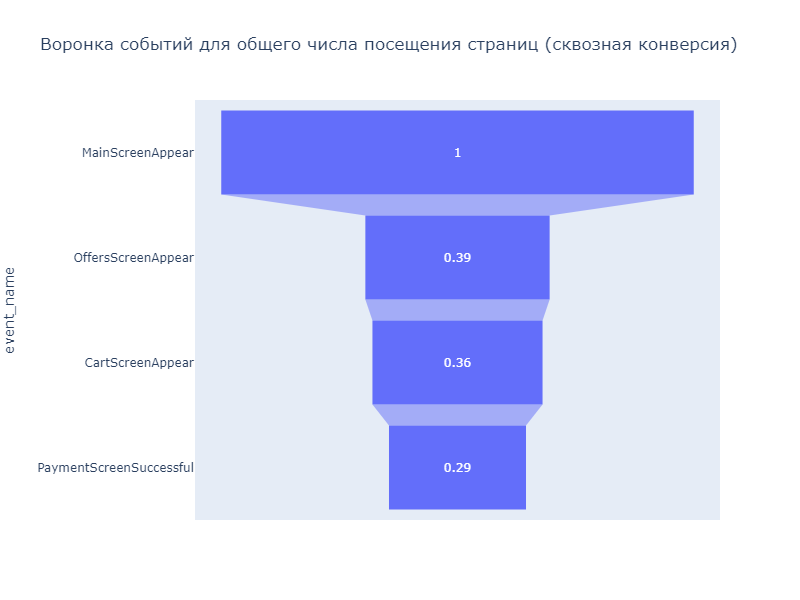

Из полученных данных видим, что наибольший провал наблюдается при переходе на страницу с предложениями

Возможно, это связано с интерфейсом приложения, расположение каталога товаров на главной странице не очевидно. Данная особенность также может быть проанализирована при дальнейших исследованиях

In [43]:
# Посчитаем, какую долю от начального события составляет каждое последующее
all_events['final_ratio']=round(all_events['cnt_users']/all_events['cnt_users'].max(),2)
all_events

event_name  cnt_users  ratio  final_ratio
0         MainScreenAppear     117328   1.00         1.00
1       OffersScreenAppear      46333   0.39         0.39
2         CartScreenAppear      42303   0.91         0.36
3  PaymentScreenSuccessful      33918   0.80         0.29

In [44]:
# Построим воронку событий по общему числу действий
fig = px.funnel(all_events, x='final_ratio', y='event_name', width=800, height=600, \
                title='Воронка событий для общего числа посещения страниц (сквозная конверсия)')
fig.show()

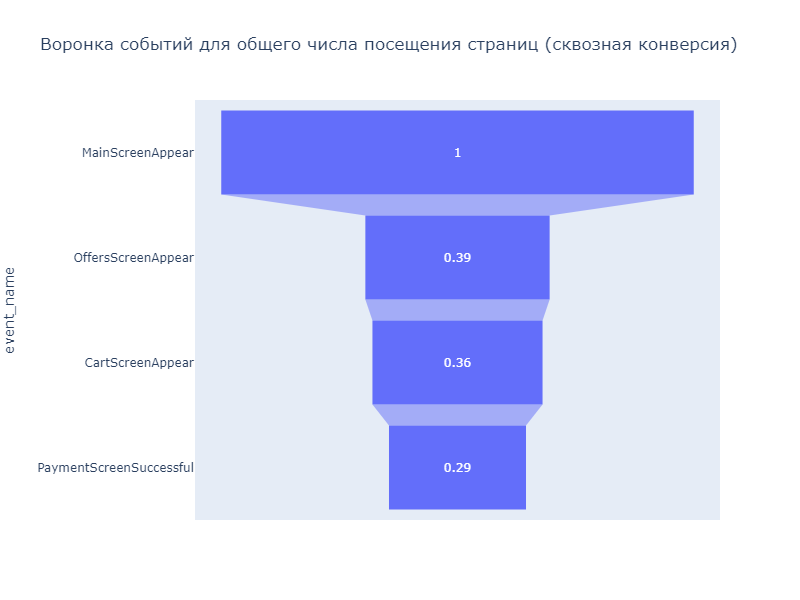

Доля частоты события оплаты по отношению к первому этапу составляет 29%

In [45]:
# Посчитаем, какая доля пользователей переходит на следующий этап
events_per_users['ratio']=round(events_per_users['cnt_users']/events_per_users['cnt_users'].shift(1), 2)
# Посчитаем отношение количества пользователей, дошедших до последнего этапа, к первому
events_per_users['final_ratio']=\
round(events_per_users['cnt_users']/events_per_users['cnt_users'].max(), 2)
events_per_users

cnt_users  share  ratio  final_ratio
event_name                                                   
MainScreenAppear              7419   0.98    NaN         1.00
OffersScreenAppear            4593   0.61   0.62         0.62
CartScreenAppear              3734   0.50   0.81         0.50
PaymentScreenSuccessful       3539   0.47   0.95         0.48
Tutorial                       840   0.11   0.24         0.11

In [46]:
# Исключим этап Tutorial
events_per_users=(
    events_per_users.reset_index()
    .query('event_name!="Tutorial"')
    .sort_values(by='cnt_users', ascending=False)
    .fillna(int(1))
)
events_per_users

event_name  cnt_users  share  ratio  final_ratio
0         MainScreenAppear       7419   0.98   1.00         1.00
1       OffersScreenAppear       4593   0.61   0.62         0.62
2         CartScreenAppear       3734   0.50   0.81         0.50
3  PaymentScreenSuccessful       3539   0.47   0.95         0.48

In [47]:
# Построим воронку событий по пользователям при переходе на следующий этап
fig = px.funnel(events_per_users, x='ratio', y='event_name', width=800, height=600,\
                title='Воронка событий для уникальных пользователей (пошаговая конверсия)')
fig.update_layout(title_x=0.1)

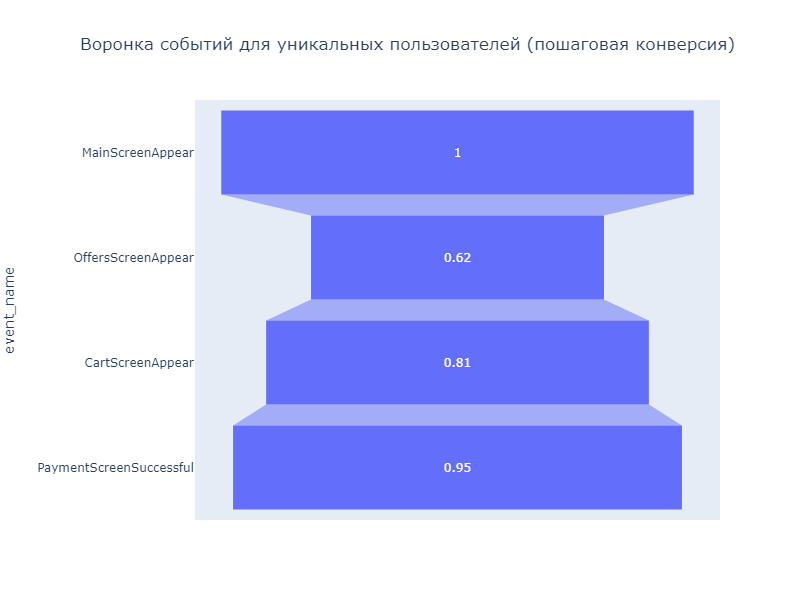

*Аналогично наблюдаем наибольшую потерю уникальных пользователей при переходе на страницу с предложениями товаров, при этом к оплате и успешному завершению покупки переходит высокий процент уникальных пользователей*

In [48]:
# Воронка пользователей по отношению к первому этапу
fig = px.funnel(events_per_users, x='final_ratio', y='event_name', width=800, height=600,\
                title='Воронка событий для уникальных пользователей (сквозная конверсия)')
fig.update_layout(title_x=0.1)

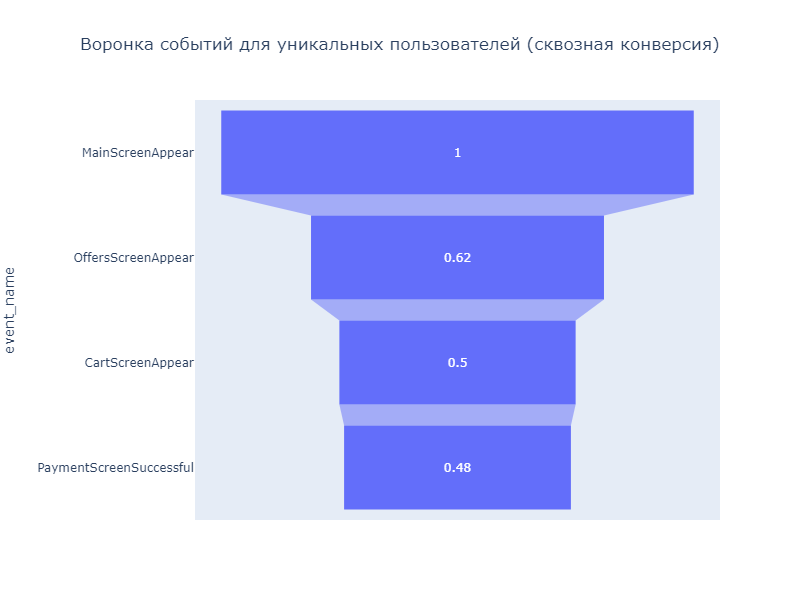

*Из полученных данных по количеству пользователей, совершивших каждое действие, также видим, что наибольшее количество пользователей уходит при переходе с главного экрана на экран с товарами.
При этом наблюдается высокий процент пользователей, которые после просмотра товаров переходят на этап оплаты и оплачивают покупку. До послднего этапа доходит 48% пользователей от первоначального количества пользователей*

#### Анализ конверсии по группам

In [49]:
# Разобьем общее количество событий по экспериментальным группам
events_exp=events(data_new,'event_name', 'user_id', 'count', 'event_name', 'exp_id')
events_exp

exp_id                     246    247    248
event_name                                  
Tutorial                   317    338    350
PaymentScreenSuccessful  11852   9981  12085
OffersScreenAppear       14767  15179  16387
MainScreenAppear         37676  39090  40562
CartScreenAppear         14690  12434  15179

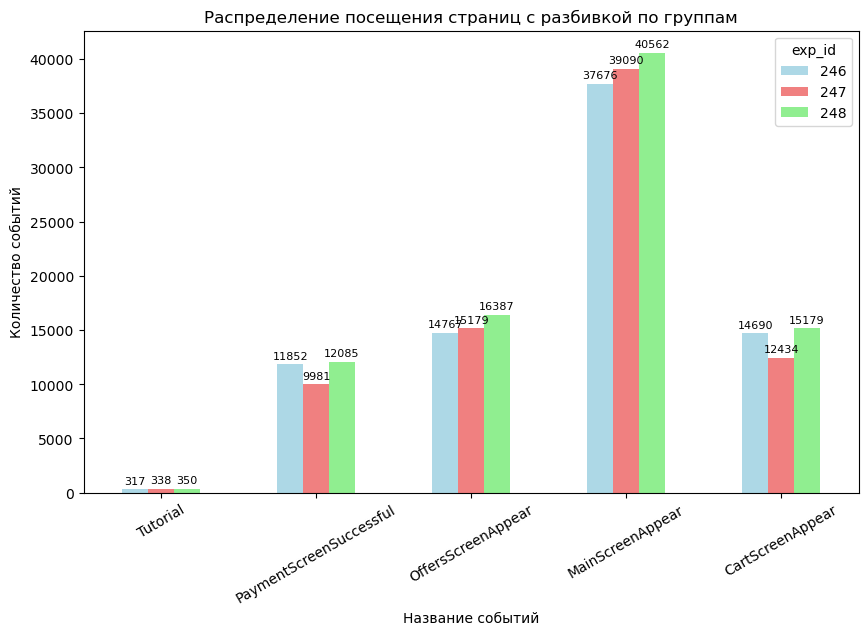

In [50]:
# Посчитаем количество событий в логах для каждой экспериментальной группы
fig, ax = plt.subplots(figsize=(10, 6))
events_exp.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral', 'lightgreen'])
for bar in ax.patches:
        ax.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 6),
                  textcoords='offset points')
plt.xticks(rotation=30)
plt.title('Распределение посещения страниц с разбивкой по группам')
plt.ylabel('Количество событий')
plt.xlabel('Название событий')
plt.show()
plt.show()

*Из полученных данных видим, что количество событий в каждой группе распределено достаточно равномерно и укладывается в общую логику воронки событий*

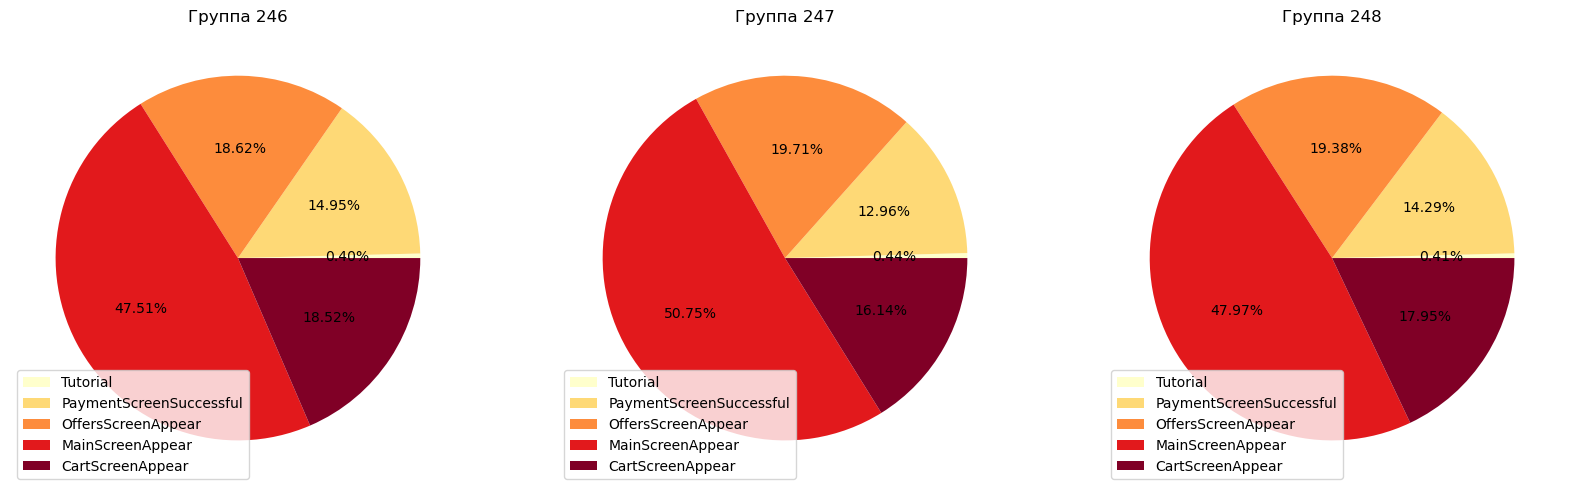

In [51]:
# Найдем доли событий в каждой группе
fig= plt.figure(figsize=(20,40))
ax1=fig.add_subplot(1, 3, 1)
ax1=events_exp[246].plot(kind='pie', labels=None, label='', autopct='%.2f%%', \
                       legend=True, title='Группа 246',cmap='YlOrRd', ax=ax1)
ax2=fig.add_subplot(1, 3, 2)
ax2=events_exp[247].plot(kind='pie', labels=None, label='', autopct='%.2f%%', \
                       legend=True, title='Группа 247',cmap='YlOrRd')
ax3=fig.add_subplot(1, 3, 3)
ax3=events_exp[248].plot(kind='pie', labels=None, label='', autopct='%.2f%%', \
                       legend=True, title='Группа 248',cmap='YlOrRd')
plt.show()

*Из представленных графиков видим, что доли событий в каждой группе распределены аналогичным образом. Наибольшую часть об общего числа событий составляет открытие главного экрана, этап обучения в основном пропускается во всех группах* 

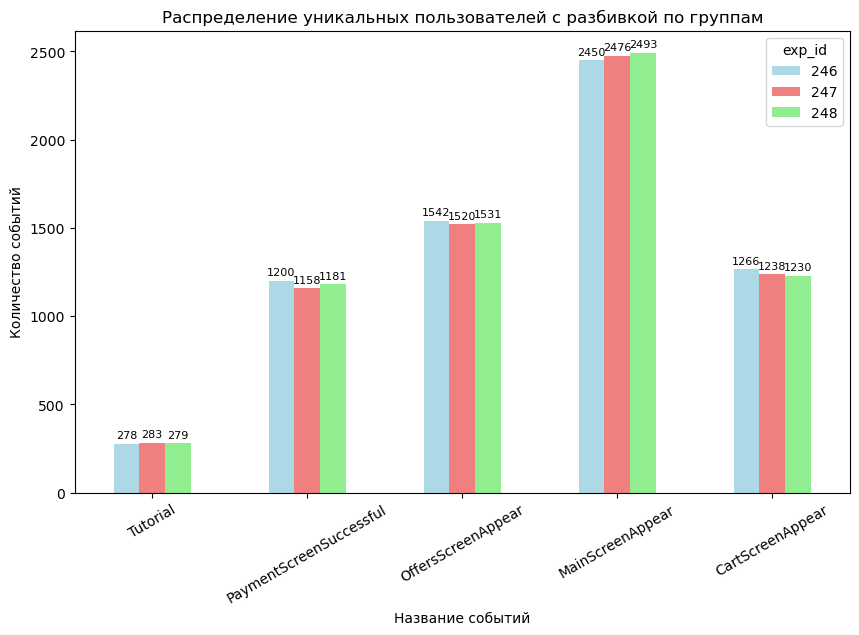

In [52]:
# Построим распределение уникальных пользователей с разбивкой по группам
users_exp=events(data_new,'event_name', 'user_id', 'nunique', 'event_name', 'exp_id')
fig, ax = plt.subplots(figsize=(10, 6))
users_exp.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral', 'lightgreen'])
for bar in ax.patches:
        ax.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 6),
                  textcoords='offset points')
plt.xticks(rotation=30)
plt.title('Распределение уникальных пользователей с разбивкой по группам')
plt.ylabel('Количество событий')
plt.xlabel('Название событий')
plt.show()
plt.show()
plt.show()

Из полученных данных также видим, что наибольшее количество пользователей приходится на открытие главного экрана, данные распределены аналогичным образом между тремя группами, так как этап обучения не входить в общий маршрут процесса покупки, исключим его из дальнейшего исследования 

In [53]:
users_exp=users_exp.query('event_name!="Tutorial"').reset_index()

In [54]:
# Выделим 246 контрольную группу в отдельную таблицу и исключим этап Tutorial из выборки
group246=users_exp.rename(columns={246:'group246'})
group246=group246[['event_name','group246']].sort_values(by='group246', ascending=False)
# Найдем отношение количества пользователей на каждом этапе к первому этапу
group246['share']=round(group246['group246']/group246['group246'].max(), 3)
group246

exp_id               event_name  group246  share
2              MainScreenAppear      2450  1.000
1            OffersScreenAppear      1542  0.629
3              CartScreenAppear      1266  0.517
0       PaymentScreenSuccessful      1200  0.490

In [55]:
# Выделим 247 контрольную группу в отдельную таблицу
group247=users_exp.rename(columns={247:'group247'})
group247=group247[['event_name','group247']].sort_values(by='group247', ascending=False)
# Найдем отношение количества пользователей на каждом этапе к первому этапу
group247['share']=round(group247['group247']/group247['group247'].max(), 3)
group247

exp_id               event_name  group247  share
2              MainScreenAppear      2476  1.000
1            OffersScreenAppear      1520  0.614
3              CartScreenAppear      1238  0.500
0       PaymentScreenSuccessful      1158  0.468

In [56]:
# Выделим 248 экспериментальную группу в отдельную таблицу
group248=users_exp.rename(columns={248:'group248'})
group248=group248[['event_name','group248']].sort_values(by='group248')
group248['share']=round(group248['group248']/group248['group248'].max(), 3)

In [57]:
# Построим воронку событий для каждой группы
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа 246',
    y = group246['event_name'],
    x = group246['share'],
    textinfo = "value"))

fig.add_trace(go.Funnel(
    name = 'Группа 247',
    y = group247['event_name'],
    x = group247['share'],
    textinfo = "value"))
fig.add_trace(go.Funnel(
    name = 'Группа 248',
    y = group248['event_name'],
    x = group248['share'],
    textinfo = "value"))
fig.update_layout(title_text='Воронка событий для уникальных пользователей (сквозная конверсия)', title_x=0.1)

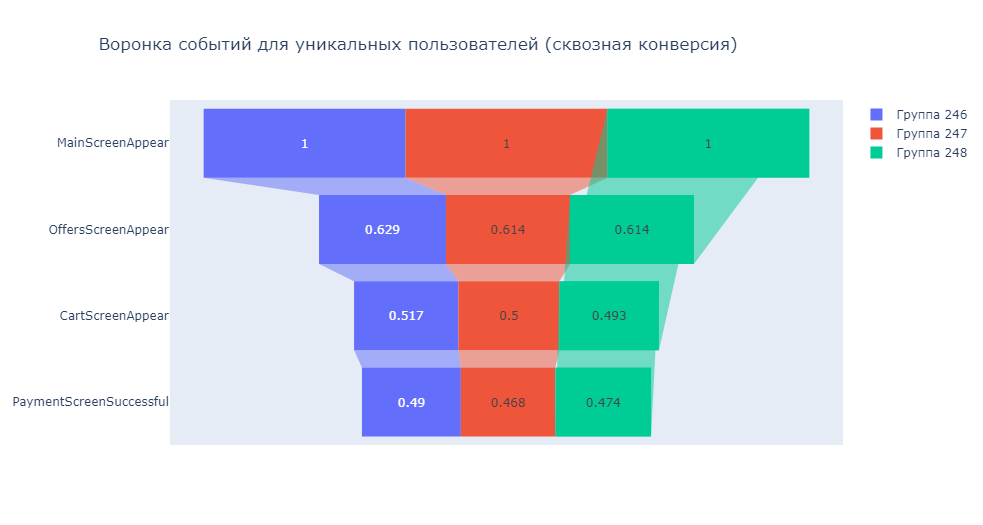

Из полученного графика видим, что во всех группах наибольшее количество пользователей отпадает при переходе на этап с предложениями. Проценты конверсии показывают близкие значения во всех группах.

В результате этапа анализа воронки событий было установлено следующее:

- Наиболее часто происходящее событие - открытие главного экрана (48% от общего числа событий)
- За ним следует страница с предложениями товаров (19% от общего числа событий)
- Далее следуют страницы с оплатой и успешное завершение оплаты (17% от общего числа событий
- Наименьшее количество раз встречается обучение (менее 1%), скорее всего, пользователи в основном пропускают данный этап 

- наибольшее падение в между этапами наблюдается при переходе с главной страницы на страницу с предложениями 
- на главный экран переходит 98% пользователей, таким образом, можно предположить, что пользователи могут перейти к страницу с товарами, минуя данный этап
- Наибольший процент пользователей теряется при переходе с главной страницы на страницу с товарами. Предположено, что это связано с интерфейсом сайта, расположение каталога товаров на главной странице не очевидно. Данная особенность также может быть проанализирована при дальнейших исследованиях. При этом к оплате и успешному завершению покупки переходит высокий процент уникальных пользователей
- До момента оплаты доходят 47% пользователей
- Обучение проходит только 11% пользователей 
- На основании анализа распределения количества событий и пользователей было предположено, что воронка событий выстраивается в следующем порядке: MainScreenAppear-OffersScreenAppear-CartScreenAppear-PaymentScreenSuccessful
- Этап Tutorial не является частью процесса покупки, поэтому не учитывался в анализе событий
- Доля частоты события оплаты по отношению к первому этапу составляет 29%


Для оценки равномерности распределения данных между группами аналогичный анализ был проведен для двух контрольных и одной экспериментальной группы. В результате анализа групп было установлено:

- доли событий в каждой группе распределены аналогичным образом. Наибольшую часть об общего числа событий составляет открытие главного экрана, этап обучения в основном пропускается во всех группах
- наибольшее количество пользователей приходится на открытие главного экрана, данные распределены аналогичным образом между тремя группами, так как этап обучения не входит в общий маршрут процесса покупки, он был исключен из дальнейшего исследования
- во всех группах наибольшее количество пользователей отпадает при переходе на этап с предложениями. 
- Проценты конверсии уникальных пользователей показывают близкие значения во всех группах (49%, 46.8%, 47.4%)

<div class="alert alert-success">
<b>Комментарий с комплиментом ревьюера:</b>
    
Корректный анализ, молодец
</div>


### Изучение результатов эксперимента

In [58]:
# Для дальнейшего анализа рещультатов эксперимента
# Найдем количество уникальных уникальных пользователей в каждой группе и распределение по событиям 
unique_users=data_new.groupby('exp_id').agg(users=('user_id', 'nunique')).T
event_data=pd.concat([unique_users,users_exp]).reset_index()
event_data=event_data.rename(columns={'index':'id', 246:'group246', 247:'group247', 248:'group248'})

In [59]:
# Для дальнейшего анализа рассчитаем суммарное количество пользователей в контрольных группах
event_data['comb']=event_data['group246']+event_data['group247']
event_data

exp_id     id  group246  group247  group248               event_name  comb
0       users      2484      2513      2537                      NaN  4997
1           0      1200      1158      1181  PaymentScreenSuccessful  2358
2           1      1542      1520      1531       OffersScreenAppear  3062
3           2      2450      2476      2493         MainScreenAppear  4926
4           3      1266      1238      1230         CartScreenAppear  2504

Для проверки корректности разбивки пользователей по группам 246 и 247 воспользуемся проверкой гипотезы о равенстве долей. Сравним конверсии каждого этапа для контрольных групп, так как мы рассматриваем 4 события, необходимо ввести поправку к уровню значимости для снижения вероятности получения ложнопозитивного результата. Также сравним кажду контрольную группу с экспериментальной для данного анализа будет проведено 12 проверок гипотез. В данном анализе воспользуемся поправкой Шидака. 
Поправку введем на 16 проверок (n=16). Так как к контрольным группам предъявляются наиболее жесткие требования по разбивкам, зададим уровень значимости 1%, для анализа контрольных и экспериментальной группы зададим уровень значимости 5%.

In [60]:
def z_value(event, group1, group2, alpha, n):
    
    success=np.array([event_data.loc[event_data['event_name']==event, group1], event_data.loc[event_data['event_name']==event, group2]])
    trials=np.array([event_data.loc[event_data['id']=='users', group1], event_data.loc[event_data['id']=='users', group2]])
#     Уровень значимости при использовании поправки Шидака
    alpha1=1-(1-alpha)**(1/n)
    # пропорция успехов в первой группе:
    p1=success[0]/trials[0]
    # пропорция успехов во второй группе:
    p2=success[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined=(success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('скорректированный уровень значимости по методу Шидака:', alpha1)
    print('p-значение: ', p_value)

    if p_value < alpha1:
        print(f"Сравнение событий {event}, Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print(
        f"Сравнение событий {event}, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
    )


Нулевая гипотеза Н0: доли в группах равны


Нулевая гипотеза Н1: доли в группах различаются

In [61]:
# Проверка долей А/А групп для события MainScreenAppear
z_value('MainScreenAppear','group246', 'group247', 0.01, 16)

скорректированный уровень значимости по методу Шидака: 0.0006279487484520674
p-значение:  [0.75705972]
Сравнение событий MainScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [62]:
# Проверка долей А/А групп для события OffersScreenAppear
z_value('OffersScreenAppear','group246', 'group247', 0.01, 16)

скорректированный уровень значимости по методу Шидака: 0.0006279487484520674
p-значение:  [0.24809546]
Сравнение событий OffersScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [63]:
# Проверка долей А/А групп для события CartScreenAppear
z_value('CartScreenAppear','group246', 'group247', 0.01, 16)

скорректированный уровень значимости по методу Шидака: 0.0006279487484520674
p-значение:  [0.22883372]
Сравнение событий CartScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [64]:
# Проверка долей А/А групп для события PaymentScreenSuccessful
z_value('PaymentScreenSuccessful','group246', 'group247', 0.01, 16)

скорректированный уровень значимости по методу Шидака: 0.0006279487484520674
p-значение:  [0.11456679]
Сравнение событий PaymentScreenSuccessful, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


*При сравнении конверсии для каждого события статистических различий между группами не выявлено. При этом для всех событий значение p-value намного выше критического уровня значимости. Контрольные группы распределены корректно*

*Сравним кажду контрольную группу с экспериментальной, зададим критерий значимости 0.05, также будем использовать поправку по методу Шидака, всего будет проведено 12 проверок гипотез*

In [65]:
# проверка долей А1/В групп для события MainScreenAppear
z_value('MainScreenAppear','group246', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.29497219]
Сравнение событий MainScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [66]:
# проверка долей А1/В групп для события OffersScreenAppear
z_value('OffersScreenAppear','group246', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.20836205]
Сравнение событий OffersScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [67]:
# проверка долей А1/В групп для события CartScreenAppear
z_value('CartScreenAppear','group246', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.07842923]
Сравнение событий CartScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [68]:
# проверка долей А1/В групп для события PaymentScreenSuccessful
z_value('PaymentScreenSuccessful','group246', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.21225533]
Сравнение событий PaymentScreenSuccessful, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [69]:
# проверка долей А2/В групп для события MainScreenAppear
z_value('MainScreenAppear','group247', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.45870536]
Сравнение событий MainScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [70]:
# проверка долей А2/В групп для события OffersScreenAppear
z_value('OffersScreenAppear','group247', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.91978178]
Сравнение событий OffersScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [71]:
# проверка долей А2/В групп для события CartScreenAppear
z_value('CartScreenAppear','group247', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.57861979]
Сравнение событий CartScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [72]:
# проверка долей А2/В групп для событияPaymentScreenSuccessful
z_value('PaymentScreenSuccessful','group247', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.73734151]
Сравнение событий PaymentScreenSuccessful, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [73]:
z_value('MainScreenAppear','comb', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.29424527]
Сравнение событий MainScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [74]:
z_value('OffersScreenAppear','comb', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.4342555]
Сравнение событий OffersScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [75]:
z_value('CartScreenAppear','comb','group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.18175875]
Сравнение событий CartScreenAppear, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [76]:
z_value('PaymentScreenSuccessful','comb', 'group248', 0.05, 16)

скорректированный уровень значимости по методу Шидака: 0.0032006977101884937
p-значение:  [0.60042943]
Сравнение событий PaymentScreenSuccessful, Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


*При сравнении конверсии для каждого события статистических различий между контрольными группами и экспериментальной не выявлено. При этом для всех событий значение p-value намного выше критического уровня значимости*

*Исходя из полученных результатов, видим, что изменение шрифта не повлияло на конверсию покупок, таким образом, можно считать эксперимент успешным и внедрить изменение шрифта в мобильном приложении*



**Общий вывод:**

В результате этапа предобработки данных были проведены следующие действия:
- столбцу с датой и временем был присвоен соответствующий формат
- удалены дубликаты
- дата события выделена в отдельный столбец
- переименованы столбцы
- установлено, что на некоторых пользователей приходится аномальное количество событий, рассчитано медианное значение событий, которое приходится на каждого пользователя
- выбросы наиболее часто встречаются для событий CartScreenAppear, paymentScreenSuccful. Возможно, это связано с тем, что пользователи сталкиваются с проблемами при оплате и дейсвтие приходится повторять несколько раз, предложено изучить этот параметр в дальнейших исследованиях
- посчитано общее количество событий
- посчитано количество уникальных пользователей
- установлено, что начало тестирования приходится на 25 июля, конец - на 7 агуста
- установлено, что в период до 1 августа было совершено 1,16% событий от общего числа событий, в этой выборке участвовали 0,22% пользователей от общего числа уникальных пользователей. Техничски возможно, что данные в первые дни могли доходить от заказов, начавшихся до старта тестирования. На основании этого сделан срез выборки и началом исследования установлено 1 августа
- установлено, что пользователи распределены по трем группам без пересечений

В результате этапа анализа воронки событий было установлено следующее:

- Наиболее часто происходящее событие - открытие главного экрана (48% от общего числа событий)
- За ним следует страница с предложениями товаров (19% от общего числа событий)
- Далее следуют страницы с оплатой и успешное завершение оплаты (17% от общего числа событий
- Наименьшее количество раз встречается обучение (менее 1%), скорее всего, пользователи в основном пропускают данный этап 

- на главный экран переходит 98% пользователей, таким образом, можно предположить, что пользователи могут перейти к страницу с товарами, минуя данный этап
- Наибольший процент пользователей теряется при переходе с главной страницы на страницу с товарами. Предположено, что это связано с интерфейсом сайта, расположение каталога товаров на главной странице не очевидно. Данная особенность также может быть проанализирована при дальнейших исследованиях
- До момента оплаты доходят 47% пользователей
- Обучение проходит только 11% пользователей 
- На основании анализа распределения количества событий и пользователей было предположено, что воронка событий выстраивается в следующем порядке: MainScreenAppear-OffersScreenAppear-CartScreenAppear-PaymentScreenSuccessful
- Этап Tutorial не является частью процесса покупки, поэтому не учитывался в анализе событий
- Доля частоты события оплаты по отношению к первому этапу составляет 29%
- Наибольшую потерю уникальных пользователей наблюдаем при переходе на страницу с предложениями товаров, при этом к оплате и успешному завершению покупки переходит высокий процент уникальных пользователей

Для оценки равномерности распределения данных между группами аналогичный анализ был проведен для двух контрольных и одной экспериментальной группы. В результате анализа групп было установлено:

- доли событий в каждой группе распределены аналогичным образом. Наибольшую часть об общего числа событий составляет открытие главного экрана, этап обучения в основном пропускается во всех группах
- наибольшее количество пользователей приходится на открытие главного экрана, данные распределены аналогичным образом между тремя группами, так как этап обучения не входит в общий маршрут процесса покупки, он был исключен из дальнейшего исследования
- во всех группах наибольшее количество пользователей отпадает при переходе на этап с предложениями товаров. 
- Проценты конверсии показывают близкие значения во всех группах (49%, 46.8%, 47.4%)

В ходе анализа результатов тестирования установлено следующее:

- Для проверки корректности разбивки пользователей по группам 246 и 247 воспользовались проверкой гипотезы о равенстве долей. Сравнили конверсии каждого этапа для контрольных групп, так как рассматривали 4 события, была введена поправку к уровню значимости для снижения вероятности получения ложнопозитивного результата. Также сравнили каждую контрольную группу с экспериментальной, для данного анализа было проведено 12 проверок гипотез. В данном анализе воспользуемся поправкой Шидака. Поправку ввели на 16 проверок (n=16). Так как к контрольным группам предъявляются наиболее жесткие требования по разбивкам, был задан уровень значимости 1%, для анализа контрольных и экспериментальной группы задан уровень значимости 5%.

- При сравнении конверсии для каждого события статистических различий между контрольными группами и экспериментальной не выявлено. При этом для всех событий значение p-value намного выше критического уровня значимости. Исходя из полученных результатов, видим, что изменение шрифта не повлияло на конверсию покупок, таким образом, можно считать эксперимент успешным и внедрить изменение шрифта в мобильном приложении.

**Рекомендации для дальнейшей работы над приложением:**

- Изучить поведение пользователей на этапе перехода к каталогу товаров, собрать обратную связь о причинах ухода с приложения на этом этапе. 

- Изучить причины часто повторяющихся действий на моменте оплаты, возможно, данные этапы имеют технические недоработки

- Закончить эксперимент и внедрить изменение шрифта